In [1]:
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years
from snowballing.strategies import Strategy
reload()


In [2]:
def busca(*libraries, seed=None, filter_function=None):
    filter_function = filter_function or (lambda x: x.category in ("snowball",))
    if seed is not None:
        iterable = ((1, work_by_varname(x)) for x in seed)
    else:
        iterable = load_work_map_all_years()
    seedset = set()
    visited = set()
    for _, work in iterable:
        for library in libraries:
            if int(getattr(work, library, 0)):
                visited.add(work)
                if filter_function(work):
                    seedset.add(work)
                break
    return seedset, filter_function, visited

def find_state(state, goal):
    stack = [state]
    visited = {id(state)}
    while stack:
        current = stack.pop()
        if goal == current.name:
            return current
        antecessors = current.previous[0] if current.previous else []
        for previous in antecessors:
            if id(previous) not in visited:
                visited.add(id(previous))
                stack.append(previous)
    return None
#busca("scopus", seed=["wohlin2014a", "briand2000a"], filter_function=lambda x: True)
#busca("scopus", filter_function=lambda x: False)

### Snowballing - Busca via FS e BS no Artigo mais Citado (Seed Set = 1)

Não realiza busca em DL.
Realiza uma busca, via Forward e/ou via Backward para encontrar artigos do seed set no artigo mais citado, exemplo, mendes2004a.

### Forward

In [3]:

#{x.metakey for x in strategy.backward().visited}


In [83]:
### Delta Related = Conector do nó
strategy = Strategy({work_by_varname("mendes2004a")})
strategy.forward().delta_related

{Web effort estimation: The value of cross-company data set compared to single-company data set,
 Building software cost estimation models using homogenous data}

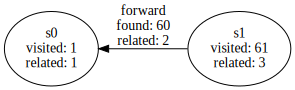

In [85]:
### Grafo
strategy = Strategy({work_by_varname("mendes2004a")})
State.last_id = 0
strategy.forward()

In [86]:
### Related do S1
strategy = Strategy({work_by_varname("mendes2004a")})
State.last_id = 0
strategy.forward().related

{Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set,
 Building software cost estimation models using homogenous data}

### Backward

In [87]:
strategy = Strategy({work_by_varname("mendes2004a")})
State.last_id = 0
strategy.backward().delta_related

{A comparison of cross-company and within-company effort estimation models for web applications}

In [88]:
strategy = Strategy({work_by_varname("mendes2004a")})
State.last_id = 0
strategy.backward().visited

{Assessment and comparison of common software cost estimation modeling techniques,
 A comparative study of two software development cost modeling techniques using multi-organizational and company-specific data,
 Investigating early web size measures for web cost estimation,
 A replicated assessment of the use of adaptation rules to improve Web cost estimation,
 How valuable is company-specific data compared to multi-company data for software cost estimation?,
 WWW2000: The Developer's view and a practitioner's approach to Web Engineering,
 Applied statistics for software managers,
 Further comparison of cross-company and within-company effort estimation models for web applications,
 An empirical validation of software cost estimation models,
 Software cost models,
 What accuracy statistics really measure,
 A replicated assessment and comparison of common software cost modeling techniques,
 A comparison of cross-company and within-company effort estimation models for web applications,
 

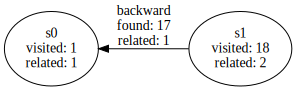

In [89]:
strategy = Strategy({work_by_varname("mendes2004a")})
State.last_id = 0
strategy.backward()

In [90]:
strategy = Strategy({work_by_varname("mendes2004a")})
State.last_id = 0
strategy.backward().name

's1'

### Snowballing - Forward and Backward - Union (N vezes)

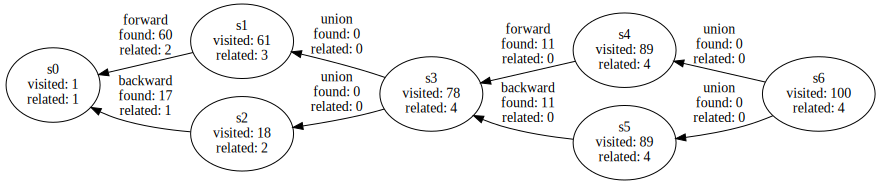

In [94]:
State.last_id = 0
state = strategy.sfbu()
state

In [97]:
print("Relacionados:")
find_state(state, "s4").delta_visited

Relacionados:


{An empirical analysis of data preprocessing for machine learning-based software cost estimation,
 La práctica de la estimación en empresas y áreas de Sistemas,
 Mining app stores: Extracting technical, business and customer rating information for analysis and prediction,
 A comparison of cross-versus single-company effort prediction models for web projects,
 Sharing data and models in software engineering,
 Effort estimation of web-based applications using machine learning techniques,
 Pattern Name: Relevancy,
 An Empirical Analysis of Three-Stage Data-Preprocessing for Analogy-Based Software Effort Estimation on the ISBSG Data,
 Empirical Assessment of Machine Learning Models for Effort Estimation of Web-based Applications,
 From Function Points to COSMIC-A Transfer Learning Approach for Effort Estimation,
 Systematic literature review on effort estimation for Open Sources (OSS) web application development}

In [13]:
print("Visitados:")
find_state(state, "s0").visited

Visitados:


{Further comparison of cross-company and within-company effort estimation models for web applications}

In [103]:
#Visualização de Backward
#state.related & set(strategy.ref[work_by_varname("mendes2004a")])

find_state(state, "s0").related & set(strategy.ref[work_by_varname("mendes2004a")])

set()

## Estratégias

### Estratégia 1 - Busca em todas Digital Libraries (DL)

In [62]:
from snowballing.strategies import State
State??

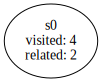

In [61]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))

state = strategy
strategy.initial

#strategy.initial.name

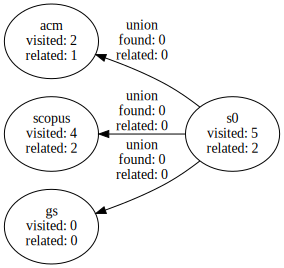

In [74]:
from snowballing.strategies import State

reload()
def busca_completa(libs, filter_function):
    union = None
    for dl in libs:
        strategy = Strategy(*busca(dl, filter_function=filter_function))
        strategy.initial.name = dl
        if union is None:
            union = strategy.initial.derive("union", name="s0")
        else:
            union.visited.update(strategy.initial.visited)
            union.related.update(strategy.initial.related)
            union.previous[0].append(strategy.initial)

    State.last_id = 0
    strategy.initial = union
    return strategy

strategy = busca_completa(["acm", "scopus", "gs"], filter_function)
#find_state(strategy.initial, "acm")
strategy.initial

In [140]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))

state = strategy
strategy.initial.visited


{Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set,
 Using public domain metrics to estimate software development effort,
 A comparative study of two software development cost modeling techniques using multi-organizational and company-specific data}

In [141]:
print ("Precision E1")
E1P = len (strategy.initial.related) / len (strategy.initial.visited)
print (E1P)

Precision E1
0.5


In [142]:
len ([x for _, x in load_work_map_all_years() if x.category == "snowball"])

4

In [143]:
print ("Recall E1")
E1R = len (strategy.initial.related) / len ([x for _, x in load_work_map_all_years() if x.category == "snowball"])
print (E1R)

Recall E1
0.5


### Estratégia 2 - Busca em todas Digital Libraries + Snowballing (Guideline - sfbu)

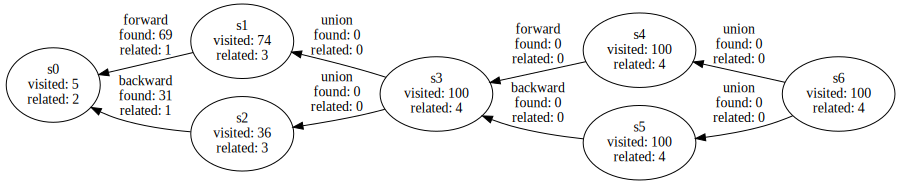

In [106]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("acm","scopus", filter_function=filter_function))

state = strategy.sfbu()
#state = strategy.bbff()
#state = strategy.ffbb()
#state = strategy.s2ffbb2u()

state

### Estratégia 3 - Busca Informal (Google Scholar) + Snowballing (Guideline - sfbu)

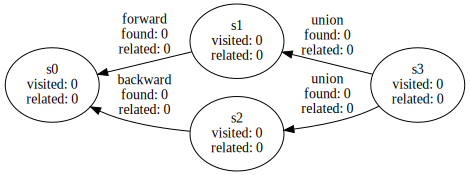

In [107]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("gs", filter_function=filter_function))
state = strategy.sfbu()
state

### Estratégia 4 - Busca em Scopus + Snowballing (Guideline - sfbu)

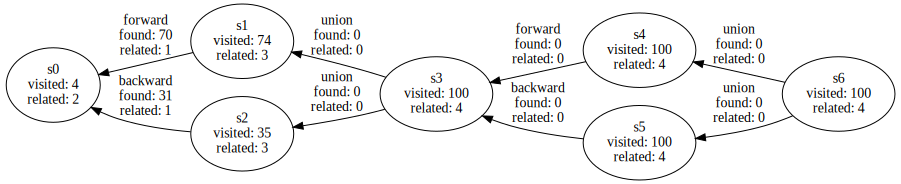

In [108]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.sfbu()
state

In [109]:
find_state(state, "s0").related

{Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set}

In [110]:
find_state(state, "s2").related

{Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set,
 A comparison of cross-company and within-company effort estimation models for web applications}

In [111]:
find_state(state, "s0").visited

{Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set,
 Using public domain metrics to estimate software development effort,
 A comparative study of two software development cost modeling techniques using multi-organizational and company-specific data}

In [112]:
# Com backward de ferrucci2012a é possível encontrar 2 (resultado da celula)
state.related & set(strategy.ref[work_by_varname("mendes2004a")])

{A comparison of cross-company and within-company effort estimation models for web applications}

In [113]:
# Com backward de ... em S2, encontrou 1 (resultado da celula)
find_state(state, "s2").delta_related & set(strategy.ref[work_by_varname("mendes2004a")])

{A comparison of cross-company and within-company effort estimation models for web applications}

In [114]:
# Com forward de ... em S1, encontrou 1 (resultado da celula)
find_state(state, "s1").delta_related & set(strategy.rev_ref[work_by_varname("mendes2004a")])

{Building software cost estimation models using homogenous data}

In [115]:
len(find_state(state, "s1").delta_visited)

70

In [116]:
#len(find_state(state, "s1").delta_visited & set(strategy.rev_ref[work_by_varname("mendes2004a")]))
# forward
len(set(strategy.rev_ref[work_by_varname("mendes2004a")]))

60

In [117]:
# backward
len(set(strategy.ref[work_by_varname("mendes2004a")]))

17

In [118]:
search_state = strategy.initial
search_state.related

{Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set}

### Estratégia 5 - Busca em Scopus + Snowballing (Short Paper - s2ffbb2u)

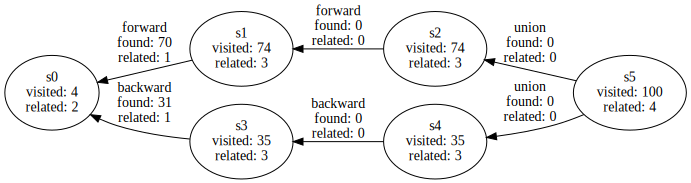

In [130]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.s2bbff2u()
state

In [134]:
sx, sy = state.previous[0]

sx.related & sy.related


{Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set}

In [135]:
sx.name

's2'

### Estratégia 6 - Busca em Scopus + Snowballing (JF - bbff)

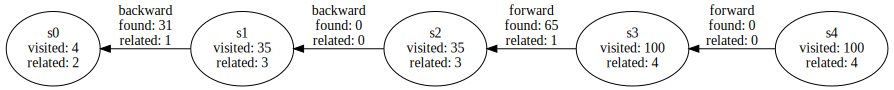

In [120]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.bbff()
state

### Estratégia 7 - Busca em Scopus + Snowballing (JF - ffbb)

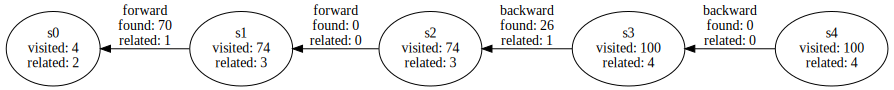

In [121]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.ffbb()
state

## Antigo

In [ ]:

s5 = find_state(state, "s5")
s5

In [ ]:
s5.delta_related

In [ ]:
state.previous[0][1].previous[0][0].related

In [ ]:
state

In [ ]:
s1 = find_state(state, "s1")
total = sum(1 for _, w in load_work_map_all_years() if w.category == "snowball")

In [ ]:
len(s1.delta_related) / len(s1.delta_visited)

In [ ]:
len(s1.delta_related) / total

In [ ]:
len(state.related) / len(state.visited)

In [ ]:
len(state.related) / total

In [ ]:
state.log

In [ ]:
len(state.visited)

In [ ]:
with open("output/snowballing.provn", "w") as provn:
    provn.write(state.provn)

In [ ]:
!provconvert.bat -infile output/snowballing.provn -outfile output/snowballing.dot

In [ ]:
with open("output/snowballing.dot", "r") as prov_dot:
    text = prov_dot.read().replace('rankdir="BT";', 'rankdir="RL"; ranksep="0.1";')
with open("output/snowballing.dot", "w") as prov_dot:
    prov_dot.write(text)

In [ ]:
!dot -Tpng output/snowballing.dot -ooutput/snowballing.png
!dot -Tsvg output/snowballing.dot -ooutput/snowballing.svg
#!inkscape -D -z --file=output/snowballing.svg --export-pdf=output/snowballing.pdf

In [ ]:
from IPython.display import Image
Image("output/snowballing.png")

In [ ]:
log = state.log

In [ ]:
len([x for _, x in load_work_map_all_years() if x.category in ('snowball','ok','backward')])

In [ ]:
from fractions import Fraction
for step in log:
    print("precision", Fraction(step.new_related, step.new_references))

In [ ]:
len([x for x in state.visited if x.category in {"snowball"}])

In [ ]:
from snowballing.approaches import get_approaches
len(get_approaches())

In [ ]:
visited = state.visited
len([(x, x.year) for x in state.visited
     if x.category in {"nofile"}
     if x.place.name != "Tech Report"
     if x.place.name != "Book"
     if x.place.name != "Patent"
     if x.place.name == "Conference"
     if x.display != x.place.acronym
    ])
#count = 0
#for x in visited:
#     if hasattr(x, 'dglibrary'):
#        print(x.dglibrary)
#        count = 1 + count
#print (count)
len([
    (x, x.year) for x in visited
     if hasattr(x, 'dglibrary') and x.dglibrary=="Scopus"
    
])

def count_ref(library,obj):
    len_dglibrary = len([(x, x.year) for x in obj
                             if hasattr(x, 'dglibrary') and library in x.dglibrary  
                        ])
    len_backward = len([(x, x.year) for x in obj
                             if x.category=="backward"  
                        ])
    len_forward = len([(x, x.year) for x in obj
                             if x.category=="forward"  
                        ])
    qtdref=0
    qtdcitations=0
    for x in obj:
        qtdref=qtdref + int(getattr(x, "references", 0))
        
    scopus = sum(int(getattr(x, "scopus", 0)) for x in obj)
            
    for x in obj:
        qtdcitations=qtdcitations + int(getattr(x, "citations", 0))
    return len_dglibrary,qtdref,qtdcitations,len_backward,len_forward
     

print ("Digital Library, Referencias, Citações, Qtd Backward, Qtd Forward")
print(count_ref("Scopus",visited))

log

print (log[0].name, log[0].new_references)
print(log[1].name, log[1].new_references)
print(log[2].name, log[2].new_references)
print(log[3].name, log[3].new_references)
print("visitados", len(visited))

In [ ]:
len([x for x in visited if x.category in {"lang"}])

In [ ]:
len([x for x in visited if x.category in {"site"}])

In [ ]:
len([x for x in visited
     if x.place.name == "Tech Report"
    ])

In [ ]:
len([x for x in visited
     if x.place.name == "ESEM"
    ])

In [ ]:
{x.category for x in visited}

In [ ]:
[(x.year, x.authors, x.name, x.place.name, x.request) for x in visited
 if x.category in {"nofile"}
 if x.place.name != "Tech Report"
 if x.place.name != "Book"
 if x.place.name != "Patent"
 if x.display != x.place.acronym]

In [ ]:
len(_)